# Configuration
- Import libraries
- Import data

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
from torch.utils.data import Subset, DataLoader

from torch.backends import cudnn

import torchvision
from torchvision import transforms

import numpy as np
import random
from skimage.util import random_noise

import os
import os.path
import sys
from torch.utils.tensorboard import SummaryWriter
sys.path.append('/content/drive/My Drive/Project Code/')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
# import our models
#!ls "/content/drive/My Drive/Project Code"
from Demp import Demp18
from SynVision import Syn_no_rotation
from SynVision import Syn_rel_rot
from SynVision import Syn_abs_rot
from Accurancy import test_acc_rgbd
from Accurancy import test_acc
from Functions import print_images
from Functions import print_images_labels
from Functions import HLoss

In [0]:
#unzip the content of synROD and ROD
!unzip "/content/drive/My Drive/Project Code/ROD.zip" -d "/content/"
!unzip "/content/drive/My Drive/Project Code/synROD.zip" -d "/content/"

# Creating dataloaders and hyper-parameters

In [0]:
# HYPER-PARAMETERS 
BATCH_SIZE  = 32
DEVICE = "cuda"
LR = 3e-4      
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2 
NUM_EPOCHS = 30   
LOG_FREQUENCY = 100
SETUP = "rotation_regr" #setup used for choosing the forward 

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
])

eval_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),                               
])

# read ROD split
rod_file = open("/content/drive/My Drive/Project Code/rod-split_sync.txt", "r") 
rod = rod_file.readlines()
rod_file.close()

# read synROD train split
syn_rod_file = open("/content/synROD/synARID_50k-split_sync_train1.txt", "r")
syn_rod = syn_rod_file.readlines()
syn_rod_file.close()

# read synROD test split
syn_rod_file = open("/content/synROD/synARID_50k-split_sync_test1.txt", "r") 
syn_rod_test = syn_rod_file.readlines()
syn_rod_file.close()

# create loaders without rotation
S_loader = Syn_no_rotation("synROD", split=syn_rod, transform=train_transform, tipo = "train")
T_loader = Syn_no_rotation("ROD", split = rod, transform=train_transform, tipo = "train") 
S_loader_test = Syn_no_rotation("synROD", split = syn_rod_test, transform=eval_transform, tipo = "test") 
T_loader_test = Syn_no_rotation("ROD", split = rod, transform=eval_transform, tipo = "test") 

# create loaders for relative rotation task
S_tilde_loader = Syn_rel_rot("synROD", split=syn_rod, transform=train_transform, setup = SETUP) 
T_tilde_loader = Syn_rel_rot("ROD", split = rod, transform=train_transform, setup = SETUP) 

# create loaders for absolute rotation task
S_tilde_loader_abs = Syn_abs_rot("synROD", split=syn_rod, transform=train_transform)
T_tilde_loader_abs = Syn_abs_rot("ROD", split = rod, transform=train_transform)

#create dataloaders for training
S_dataloader = DataLoader(S_loader, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
T_dataloader = DataLoader(T_loader, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

#create dataloaders for relative rotation task
S_tilde_dataloader = DataLoader(S_tilde_loader, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
T_tilde_dataloader = DataLoader(T_tilde_loader, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

#create dataloaders for absolute rotation task
S_tilde_dataloader_abs = DataLoader(S_tilde_loader_abs, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
T_tilde_dataloader_abs = DataLoader(T_tilde_loader_abs, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

# create dataloaders for testing
S_dataloader_test = DataLoader(S_loader_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
T_dataloader_test = DataLoader(T_loader_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

max_batches = len(S_tilde_dataloader)
min_batches = len(T_tilde_dataloader)

max_batches_abs = len(S_tilde_dataloader_abs)
min_batches_abs = len(T_tilde_dataloader_abs)
NUM_CLASSES = len(set(S_dataloader.dataset.labels))

# Print images

tensor(0.9120, dtype=torch.float64)
tensor(0.4102, dtype=torch.float64)
Angle 24.21606141390943 labels 6


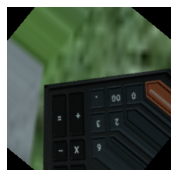

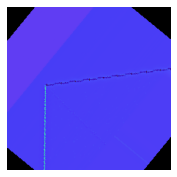

In [0]:
print_images_labels(S_tilde_dataloader_abs)

tensor(0.7293, dtype=torch.float64)
tensor(-0.6842, dtype=torch.float64)
Angle -43.175363725406555 labels 16


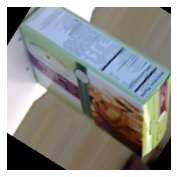

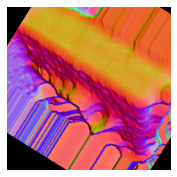

In [0]:
# The angle could return negative because we use the arctan function, defined between -pi and +pi
print_images_labels(T_tilde_dataloader_abs)

tensor(0.2591, dtype=torch.float64)
tensor(-0.9659, dtype=torch.float64)
Angle -74.98488043254852 labels 24


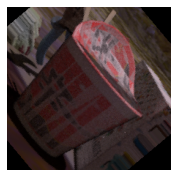

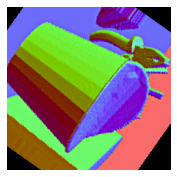

In [0]:
print_images_labels(S_tilde_dataloader)

tensor(0.9531, dtype=torch.float64)
tensor(0.3028, dtype=torch.float64)
Angle 17.623340669234043 labels 11


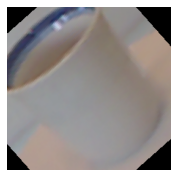

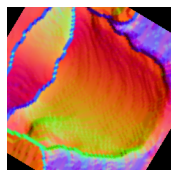

In [0]:
print_images_labels(T_tilde_dataloader)

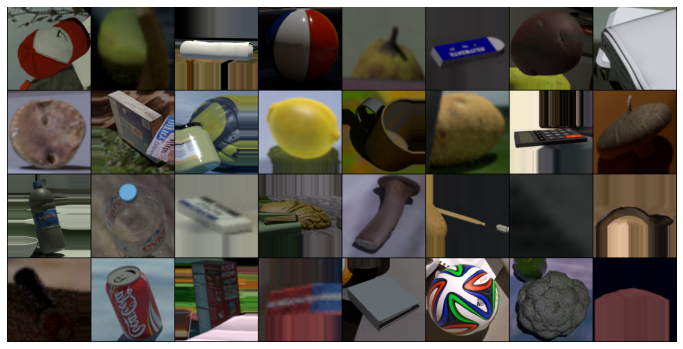

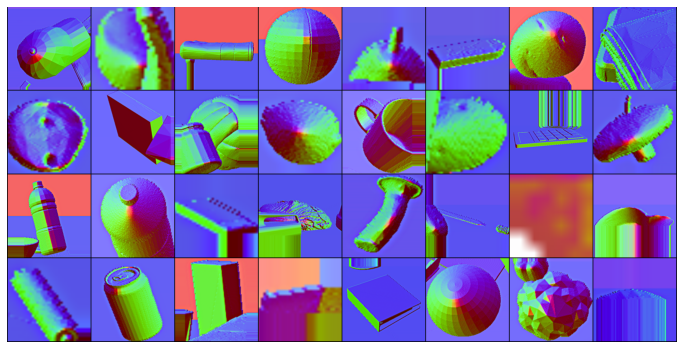

In [0]:
print_images(S_dataloader)

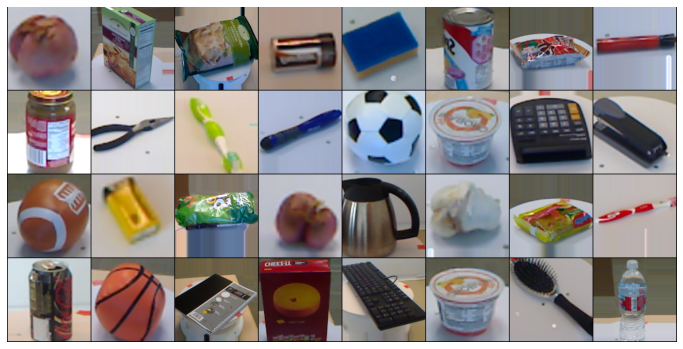

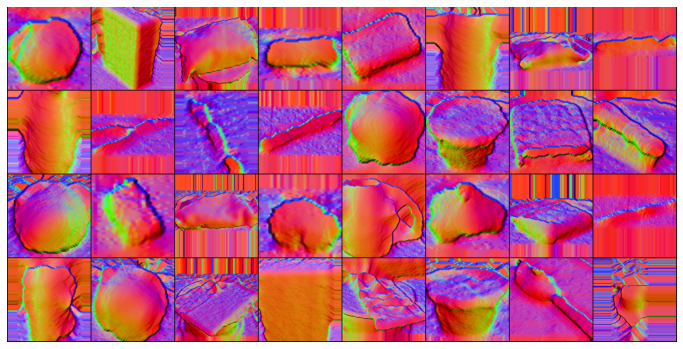

In [0]:
print_images(T_dataloader)

# Net inizialiation

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)

In [0]:
loss_classification = nn.CrossEntropyLoss() 
#loss_cos = nn.MSELoss()
#loss_sin = nn.MSELoss()
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE) 

#Source only: RGB

In [0]:
LR = 3e-4      
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2 
NUM_EPOCHS = 25    
LOG_FREQUENCY = 100
SETUP = "standard"

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)
loss_classification = nn.CrossEntropyLoss() 
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 

In [0]:
net = torch.load('/content/drive/My Drive/Project Code/net_RGB_ONLY.pth')
optimizer = torch.load('/content/drive/My Drive/Project Code/opt_RGB_ONLY.pth')

In [0]:
cudnn.benchmark 
batch_idx = 0

for epoch in range(28):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  for S_rgb, S_depth, S_labels in S_dataloader:
    S_rgb = S_rgb.to(DEVICE)
    S_labels = S_labels.to(DEVICE)

    net.train() 
    if batch_idx % 2 == 0: #gradient accumulation
      optimizer.zero_grad() 
    S_classes = net(S_rgb)
    loss_S = loss_classification(S_classes, S_labels) #Compute loss_m
    loss_S.backward()

    if (batch_idx % LOG_FREQUENCY == 0):
        print('Step {}, Loss_S {}'.format(batch_idx, loss_S.item()))
    
    if (batch_idx+1) % 2 == 0: #gradient accumulation
      optimizer.step()  
    batch_idx += 1

  #scheduler.step() 
  torch.save(net, '/content/drive/My Drive/net_RGB_ONLY_BS64.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt_RGB_ONLY_BS64.pth')
  acc = test_acc(net, T_dataloader_test, DEVICE, tipo = "rgb")

#Source only: depth

In [0]:
LR = 3e-4      
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2 
NUM_EPOCHS = 25    
LOG_FREQUENCY = 100
SETUP = "standard"

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)
loss_classification = nn.CrossEntropyLoss() 
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 

In [0]:
net = torch.load('/content/drive/My Drive/Project Code/net_Depth_only.pth')
optimizer = torch.load('/content/drive/My Drive/Project Code/opt_Depth_only.pth')

In [0]:
cudnn.benchmark 
batch_idx = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  for S_rgb, S_depth, S_labels in S_dataloader:
    S_labels = S_labels.to(DEVICE)
    S_depth = S_depth.to(DEVICE)

    net.train() 
    if batch_idx % 2 == 0: #gradient accumulation
      optimizer.zero_grad() 
    S_classes = net(S_depth)
    loss_S = loss_classification(S_classes, S_labels) #compute loss_m
    loss_S.backward()

    if (batch_idx % LOG_FREQUENCY == 0):
        print('Step {},Loss_S {}'.format(batch_idx, loss_S.item()))

    if (batch_idx+1) % 2 == 0: #gradient accumulation
      optimizer.step()  
    batch_idx += 1
    
    optimizer.step() 
    batch_idx += 1
 
  torch.save(net, '/content/drive/My Drive/net_Depth_only.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt_Depth_only.pth')
  acc = test_acc(net, T_dataloader_test, DEVICE, tipo = "depth")

#Source only: RGBD e2e

In [0]:
LR = 3e-4      
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-2 
NUM_EPOCHS = 25    
LOG_FREQUENCY = 100
SETUP = "rgbde2e"

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)
loss_classification = nn.CrossEntropyLoss() 
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 

In [0]:
cudnn.benchmark 
batch_idx = 0

for epoch in range(10):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  for S_rgb, S_depth, S_labels in S_dataloader:
    S_rgb = S_rgb.to(DEVICE)
    S_labels = S_labels.to(DEVICE)
    S_depth = S_depth.to(DEVICE)

    net.train() 
    if batch_idx % 2 == 0: #gradient accumulation
      optimizer.zero_grad() 
    S_classes = net(S_rgb, S_depth)
    loss_S = loss_classification(S_classes, S_labels) # compute loss_m
    loss_S.backward()

    if (batch_idx % LOG_FREQUENCY == 0):
        print('Step {},Loss_S {}'.format(batch_idx, loss_S.item()))

    if (batch_idx+1) % 2 == 0: #gradient accumulation
      optimizer.step()  
    batch_idx += 1

  
  torch.save(net, '/content/drive/My Drive/net_RGBDe2e.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt_RGBDe2e.pth')
  #includi salvataggio optimizer
  acc = test_acc_rgbd(net, T_dataloader_test, DEVICE)


#Loghmani et al. implementation (ours experiment)

In [0]:
net = Demp18(pretrained = True, num_classes = NUM
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 

In [0]:
net = torch.load('/content/drive/My Drive/RGBD_OURS.pth')
optimizer = torch.load('/content/drive/My Drive/opt.pth')

In [0]:
cudnn.benchmark # Calling this optimizes runtime
lambda_factor = 0.1
lambda_p = 1

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  S_iter = iter(S_dataloader)
  T_iter = iter(T_dataloader)
  S_tilde_iter = iter(S_tilde_dataloader)
  T_tilde_iter = iter(T_tilde_dataloader)
  for batch_idx in range(max_batches):
    
    if batch_idx == min_batches: 
      #we iteratate again on the set T because is smaller than the set S
       T_iter = iter(T_dataloader)
       T_tilde_iter = iter(T_tilde_dataloader)

    # load batches from S, T, S_tilde, T_tilde
    S_rgb, S_depth, S_labels = next(S_iter)
    T_rgb, T_depth, T_labels = next(T_iter)
    St_rgb, St_depth, St_angles, St_labels = next(S_tilde_iter)
    Tt_rgb, Tt_depth, Tt_angles, Tt_labels = next(T_tilde_iter)

    S_rgb = S_rgb.to(DEVICE)
    S_labels = S_labels.to(DEVICE)
    S_depth = S_depth.to(DEVICE)
    T_rgb = T_rgb.to(DEVICE)
    T_labels = T_labels.to(DEVICE)
    T_depth = T_depth.to(DEVICE)
    St_rgb = St_rgb.to(DEVICE)
    St_labels = St_labels.to(DEVICE)
    St_depth = St_depth.to(DEVICE)
    St_angles = St_angles.to(DEVICE)
    Tt_rgb = Tt_rgb.to(DEVICE)
    Tt_labels = Tt_labels.to(DEVICE)
    Tt_depth = Tt_depth.to(DEVICE)
    Tt_angles = Tt_angles.to(DEVICE)
    
    net.train() 
    if batch_idx % 2 == 0: #gradient accumulation
      optimizer.zero_grad() 

    # compute predictions
    S_classes = net(S_rgb, S_depth) 
    T_classes = net(T_rgb, T_depth)
    St_ang, St_classes = net(St_rgb, St_depth, setup = SETUP)
    Tt_ang, Tt_classes = net(Tt_rgb, Tt_depth, setup = SETUP)
    
    loss_S = loss_classification(S_classes, S_labels) #compute loss_m
    loss_St = loss_rotation(St_ang, St_angles) #compute loss_p from S
    loss_Tt = loss_rotation(Tt_ang, Tt_angles) #compute loss_p from T
    loss_en = loss_entropy(T_classes) * lambda_factor
    
    loss = loss_S + loss_en + lambda_p*(loss_St + loss_Tt) #sum all the losses
    loss.backward()

    if batch_idx % 100 == 0:
        print('Step {}, Loss {}, Loss_en {}, Loss_S {}, Loss_St {}, loss_Tt {}'.format(batch_idx, loss.item(), loss_en.item(),
                                                                                         loss_S.item(),  lambda_p*loss_St.item(), lambda_p*loss_Tt.item()))
    if (batch_idx+1) % 2 == 0: #gradient accumulation
      optimizer.step() 
      

  torch.save(net, '/content/drive/My Drive/RGBD_OURS.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt.pth')
  acc = test_acc_rgbd(net, T_dataloader_test, DEVICE)
  print('Loss:{}\nTest acc: {}\n'.format(loss.item(), acc))

#Variant 1: relative rotation as regression

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)
loss_classification = nn.CrossEntropyLoss() 
loss_cos = nn.MSELoss()
loss_sin = nn.MSELoss()
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 
SETUP = "rotation_regr" 

In [0]:
net = torch.load('/content/drive/My Drive/Project Code/net weights/RGBD_net_rotation.pth')
optimizer = torch.load('/content/drive/My Drive/Project Code/net weights/RGBD_opt_rotation.pth')

In [0]:
current_step = 0
lambda_p = 0.5
lambda_factor = 0.1
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  S_tilde_iter = iter(S_tilde_dataloader)
  T_tilde_iter = iter(T_tilde_dataloader)
  S_iter = iter(S_dataloader)
  T_iter = iter(T_dataloader)
  for batch_idx in range(max_batches):

    if batch_idx == min_batches:
      #we iteratate again on the set T because is smaller than the set S
       T_iter = iter(T_dataloader)
       T_tilde_iter = iter(T_tilde_dataloader)

    # load batches from S, T, S_tilde, T_tilde
    S_rgb, S_depth, S_labels = next(S_iter)
    T_rgb, T_depth, T_labels = next(T_iter)
    St_rgb, St_depth, St_cos, St_sin, St_labels = next(S_tilde_iter)
    Tt_rgb, Tt_depth, Tt_cos, Tt_sin, Tt_labels = next(T_tilde_iter)
    
    S_rgb = S_rgb.to(DEVICE)
    S_labels = S_labels.to(DEVICE)
    S_depth = S_depth.to(DEVICE)
    T_rgb = T_rgb.to(DEVICE)
    T_labels = T_labels.to(DEVICE)
    T_depth = T_depth.to(DEVICE)
    St_rgb = St_rgb.to(DEVICE)
    St_depth = St_depth.to(DEVICE)
    Tt_rgb = Tt_rgb.to(DEVICE)
    Tt_depth = Tt_depth.to(DEVICE)
    St_cos = St_cos.type(torch.float32).to(DEVICE)
    St_sin = St_sin.type(torch.float32).to(DEVICE)
    Tt_cos = Tt_cos.type(torch.float32).to(DEVICE)
    Tt_sin = Tt_sin.type(torch.float32).to(DEVICE)
    
    net.train() 
    if batch_idx % 2 == 0:
      optimizer.zero_grad() 

    # compute predictions
    S_classes = net(S_rgb, S_depth) 
    T_classes = net(T_rgb, T_depth)
    St_cos_pred, St_sin_pred = net(St_rgb, St_depth, setup = SETUP)
    Tt_cos_pred, Tt_sin_pred = net(Tt_rgb, Tt_depth, setup = SETUP)
    
    Tt_cos = Tt_cos.unsqueeze(1)
    Tt_sin = Tt_sin.unsqueeze(1)
    St_sin = St_sin.unsqueeze(1)
    St_cos = St_cos.unsqueeze(1)

    loss_S = loss_classification(S_classes, S_labels) #compute loss_m
    loss_en = loss_entropy(T_classes) * lambda_factor #compute loss_en
    lossS_cos = loss_cos(St_cos_pred, St_cos) #compute loss_cos_S
    lossS_sin = loss_sin(St_sin_pred, St_sin) #compute loss_sin_S
    lossT_cos = loss_cos(Tt_cos_pred, Tt_cos) #compute loss_cos_T
    lossT_sin = loss_sin(Tt_sin_pred, Tt_sin) #compute loss_sin_T
    
    loss = loss_S + loss_en + lambda_p*(lossS_cos + lossS_sin + lossT_cos + lossT_sin) #sum all the losses
    loss.backward()
    if (batch_idx % LOG_FREQUENCY == 0):
        print('Step {}, Loss {}, loss_en {}, loss_S {}, lossS_cos {}, lossS_sin {}, lossT_cos {}, lossT_sin {}'.format(batch_idx, loss.item(), loss_en.item(), loss_S.item(), lambda_p*lossS_cos.item(), lambda_p*lossS_sin.item(), lambda_p*lossT_cos.item(), lambda_p*lossT_sin.item()))
    
    if (batch_idx + 1) % 2 == 0:
      optimizer.step() 

  acc = test_acc_rgbd(net, T_dataloader, DEVICE)
  torch.save(net, '/content/drive/My Drive/net_rot_regr.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt_rot_regr.pth')
  print('Step {}, Loss:{}\nTest acc: {}\n'.format(batch_idx, loss.item(), acc))

# Variant 2: absolute rotation as regression

In [0]:
net = Demp18(pretrained = True, num_classes = NUM_CLASSES)
loss_classification = nn.CrossEntropyLoss() 
loss_cos = nn.MSELoss()
loss_sin = nn.MSELoss()
loss_entropy = HLoss()
loss_rotation = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

net = net.to(DEVICE) 
SETUP = "rotation_regr" 

In [0]:
net = torch.load('/content/drive/My Drive/net_rot_abs.pth')
optimier = torch.load('/content/drive/My Drive/opt_rot_abs.pth')

In [0]:
batch_idx = 0
lambda_p = 0.5
lambda_factor = 0.1
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, LR))
  # S_tilde_iter and T_tilde_iter are different from the previous experiment
  S_tilde_iter = iter(S_tilde_dataloader_abs)
  T_tilde_iter = iter(T_tilde_dataloader_abs)
  S_iter = iter(S_dataloader)
  T_iter = iter(T_dataloader)
  for batch_idx in range(max_batches_abs):

    if batch_idx == min_batches_abs:
      #we iteratate again on the set T because is smaller than the set S
       T_iter = iter(T_dataloader)
       T_tilde_iter = iter(T_tilde_dataloader_abs)

    # load batches from S, T, S_tilde, T_tilde
    S_rgb, S_depth, S_labels = next(S_iter)
    T_rgb, T_depth, T_labels = next(T_iter)
    St_rgb, St_depth, St_cos, St_sin, St_labels = next(S_tilde_iter)
    Tt_rgb, Tt_depth, Tt_cos, Tt_sin, Tt_labels = next(T_tilde_iter)
    
    S_rgb = S_rgb.to(DEVICE)
    S_labels = S_labels.to(DEVICE)
    S_depth = S_depth.to(DEVICE)

    T_rgb = T_rgb.to(DEVICE)
    T_labels = T_labels.to(DEVICE)
    T_depth = T_depth.to(DEVICE)
    St_rgb = St_rgb.to(DEVICE)
    St_depth = St_depth.to(DEVICE)
    Tt_rgb = Tt_rgb.to(DEVICE)
    Tt_depth = Tt_depth.to(DEVICE)
    St_cos = St_cos.type(torch.float32).to(DEVICE)
    St_sin = St_sin.type(torch.float32).to(DEVICE)
    Tt_cos = Tt_cos.type(torch.float32).to(DEVICE)
    Tt_sin = Tt_sin.type(torch.float32).to(DEVICE)
    
    net.train() 
    if batch_idx % 2 == 0:
      optimizer.zero_grad() 

    S_classes = net(S_rgb, S_depth) 
    T_classes = net(T_rgb, T_depth)
    St_cos_pred, St_sin_pred = net(St_rgb, St_depth, setup = SETUP)
    Tt_cos_pred, Tt_sin_pred = net(Tt_rgb, Tt_depth, setup = SETUP)
    
    Tt_cos = Tt_cos.unsqueeze(1)
    Tt_sin = Tt_sin.unsqueeze(1)
    St_sin = St_sin.unsqueeze(1)
    St_cos = St_cos.unsqueeze(1)

    loss_S = loss_classification(S_classes, S_labels) #compute loss_m
    loss_en = loss_entropy(T_classes) * lambda_factor #compute loss_en
    lossS_cos = loss_cos(St_cos_pred, St_cos) #compute loss_cos_S
    lossS_sin = loss_sin(St_sin_pred, St_sin) #compute loss_sin_S
    lossT_cos = loss_cos(Tt_cos_pred, Tt_cos) #compute loss_cos_T
    lossT_sin = loss_sin(Tt_sin_pred, Tt_sin) #compute loss_sin_T
    
    
    loss = loss_S + loss_en + lambda_p*(lossS_cos + lossS_sin + lossT_cos + lossT_sin) #sum all the losses
    loss.backward()
    if (batch_idx % LOG_FREQUENCY == 0):
        print('Step {}, Loss {}, loss_en {}, loss_S {}, lossS_cos {}, lossS_sin {}, lossT_cos {}, lossT_sin {}'.format(batch_idx, loss.item(), loss_en.item(), loss_S.item(), lambda_p*lossS_cos.item(), lambda_p*lossS_sin.item(), lambda_p*lossT_cos.item(), lambda_p*lossT_sin.item()))
    
    if (batch_idx + 1) % 2 == 0:
      optimizer.step() 

  acc = test_acc_rgbd(net, T_dataloader, DEVICE)
  torch.save(net, '/content/drive/My Drive/net_rot_abs.pth')
  torch.save(optimizer, '/content/drive/My Drive/opt_rot_abs.pth')
  print('Step {}, Loss:{}\nTest acc: {}\n'.format(batch_idx, loss.item(), acc))
  #print('Step {}, Loss:{}\nTest acc: {}\nR2_avg: {}'.format(current_step, loss.item(), acc))

# TSNE

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'Demp.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


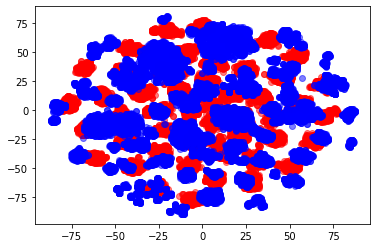

In [0]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

net = torch.load('/content/drive/My Drive/RGBD_OURS.pth')
optimizer = torch.load('/content/drive/My Drive/opt.pth')

S_iter = iter(S_dataloader)
T_iter = iter(T_dataloader)
scaler = StandardScaler()

x_s = None
x_t = None
x_new = None
x_new_1 = None
contatore = 0

for indice in range(len(train_loader)):
    S_rgb, S_depth, S_labels = next(S_iter)
    T_rgb, T_depth, T_labels = next(T_iter)
    S_rgb = S_rgb.to(DEVICE)
    S_depth = S_depth.to(DEVICE)

    T_rgb = T_rgb.to(DEVICE)
    T_depth = T_depth.to(DEVICE)
    vector_s = net(S_rgb, S_depth, "tsne")
    vector_t = net(T_rgb, T_depth, "tsne")
    X_s = vector_s.double().cpu().detach().numpy()
    X_t = vector_t.double().cpu().detach().numpy()
    if x_s is None:
      x_s = X_s
      x_t = X_t
    else:
      x_s = np.concatenate((x_s, X_s))
      x_t = np.concatenate((x_t, X_t))
    contatore += 1
    if contatore == 500:
        break;


x_s = scaler.fit_transform(x_s)
tsne = TSNE(n_components=2)
x_ts_1 = tsne.fit_transform(x_s)
plt.scatter(x_ts_1[:,0], x_ts_1[:,1], c = "r", alpha = 0.5)
x_t = scaler.fit_transform(x_t)
tsne = TSNE(n_components=2)
x_ts_2 = tsne.fit_transform(x_t)
plt.scatter(x_ts_2[:,0], x_ts_2[:,1], c = "b", alpha = 0.5)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'Demp.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


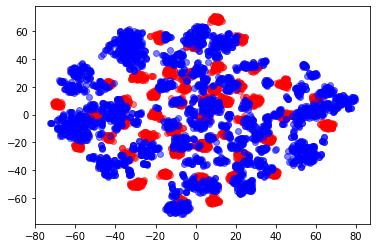

In [0]:
net = torch.load('/content/drive/My Drive/net_RGBDe2e.pth')
optimizer = torch.load('/content/drive/My Drive/opt_RGBDe2e.pth')

S_iter = iter(S_dataloader)
T_iter = iter(T_dataloader)
scaler = StandardScaler()

x_s = None
x_t = None
x_new = None
x_new_1 = None
contatore = 0

for indice in range(len(train_loader)):
    S_rgb, S_depth, S_labels = next(S_iter)
    T_rgb, T_depth, T_labels = next(T_iter)
    S_rgb = S_rgb.to(DEVICE)
    S_depth = S_depth.to(DEVICE)

    T_rgb = T_rgb.to(DEVICE)
    T_depth = T_depth.to(DEVICE)
    vector_s = net(S_rgb, S_depth, "tsne")
    vector_t = net(T_rgb, T_depth, "tsne")
    X_s = vector_s.double().cpu().detach().numpy()
    X_t = vector_t.double().cpu().detach().numpy()
    if x_s is None:
      x_s = X_s
      x_t = X_t
    else:
      x_s = np.concatenate((x_s, X_s))
      x_t = np.concatenate((x_t, X_t))
    contatore += 1
    if contatore == 100:
        break;


x_s = scaler.fit_transform(x_s)
tsne = TSNE(n_components=2)
x_ts_1 = tsne.fit_transform(x_s)
plt.scatter(x_ts_1[:,0], x_ts_1[:,1], c = "r", alpha = 0.5)
x_t = scaler.fit_transform(x_t)
tsne = TSNE(n_components=2)
x_ts_2 = tsne.fit_transform(x_t)
plt.scatter(x_ts_2[:,0], x_ts_2[:,1], c = "b", alpha = 0.5)